In [20]:
from synthcity.metrics.eval import Metrics
import pandas as pd
def synthcity_evaluate(real_path,
                       syn_path,
                       result_name=None,
                       real_size = None,
                       syn_size = None):
    real_data = pd.read_csv(real_path)
    syn_data = pd.read_csv(syn_path)
    
    if real_size and real_size < len(real_data):
        real_data = real_data.sample(n=real_size, random_state=42)  # Adjust random_state as desired for reproducibility

    if syn_size and syn_size < len(syn_data):
        syn_data = syn_data.sample(n=syn_size, random_state=42)
    
    metrics = {
        'sanity': ['data_mismatch', 'nearest_syn_neighbor_distance', 'close_values_probability'],
        'stats': ['jensenshannon_dist', 'feature_corr', 'ks_test', 'max_mean_discrepancy', 'prdc', 'alpha_precision'],
        'performance': ['linear_model', 'mlp', 'xgb'],
        # 'detection': ['detection_xgb', 'detection_mlp', 'detection_linear'],
        # 'privacy': ['delta-presence', 'k-anonymization', 'k-map', 'distinct l-diversity', 'identifiability_score']
    }
    
    synthcity_result = Metrics.evaluate(real_data, syn_data, metrics=metrics)
    if result_name:
        synthcity_result.to_csv(result_name)
    return synthcity_result
    
    
def compare(real_file_name, no_water_mark_file_name, with_water_mark_file_name, size=200, round_to=None):
    samples_dir = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples/"
    real_path = samples_dir + real_file_name
    synth_no_watermark_path = samples_dir + no_water_mark_file_name
    synth_with_watermark_path = samples_dir + with_water_mark_file_name
    
    
    real_df = synthcity_evaluate(real_path, real_path, real_size=size, syn_size=size)[["min"]]
    no_water_mark_df = synthcity_evaluate(real_path, synth_no_watermark_path, real_size=size, syn_size=size)[["min"]]
    with_watermark_df = synthcity_evaluate(real_path, synth_with_watermark_path, real_size=size, syn_size=size)[["min", "direction"]]
    merge_result = real_df.join(no_water_mark_df, lsuffix='_real', rsuffix='_no_watermark')
    merge_result_final = merge_result.join(with_watermark_df)
    
    merge_result_final.columns = ["Real Data", "No-Watermark", "With-Watermark", "Direction"]
    if round_to:
        merge_result_final = merge_result_final.round(round_to)
    return merge_result_final



In [81]:
"""
Compute one single score for data quality
Compute the average z-score of synthetic data (over a number of samples)
"""
from watermarking.great_watermark import GreatWatermarkLogitProcessor, GreatWatermarkDetector
import transformers

def average_data_quality(real_file_name, no_water_mark_file_name, with_water_mark_file_name, size=200):
    """
    Compute the average quality of synthetic data, with watermarks and without watermarks
    The scores are divided into 3 groups: resemblance, ML utility and discriminatory 
    Args:
        real_file_name: 
        no_water_mark_file_name: 
        with_water_mark_file_name: 
        size: default to 200 tokens
    """

    scores = compare(
        real_file_name = real_file_name,
        no_water_mark_file_name = no_water_mark_file_name,
        with_water_mark_file_name = with_water_mark_file_name,
        size = size
    )
    
    for col in ['Real Data', 'No-Watermark', 'With-Watermark']:
        scores[col] = scores.apply(lambda row: 1 - row[col] if row['Direction'] == 'minimize' else row[col], axis=1)
    
    scores =  scores.drop('Direction', axis=1)
    scores = scores.astype(float)

    # Resemblance
    resemblance_metrics = ['stats.jensenshannon_dist.marginal',
                           'stats.ks_test.marginal',
                           'stats.max_mean_discrepancy.joint',
               'stats.prdc.precision', 'stats.prdc.recall', 'stats.prdc.density', 'stats.prdc.coverage',
               'stats.alpha_precision.delta_precision_alpha_OC', 'stats.alpha_precision.delta_coverage_beta_OC',
               'stats.alpha_precision.authenticity_OC', 'stats.alpha_precision.delta_precision_alpha_naive',
               'stats.alpha_precision.delta_coverage_beta_naive', 'stats.alpha_precision.authenticity_naive'],
    resemblance_df = scores.loc[resemblance_metrics]  
    resemblance_scores = resemblance_df[['No-Watermark', 'With-Watermark']].mean()
    
    # ML utility metrics
    linear_performance = scores.loc['performance.linear_model.syn_id'] / scores.loc['performance.linear_model.gt']
    mlp_performance = scores.loc['performance.mlp.syn_id'] / scores.loc['performance.mlp.gt']
    xgb_performance = scores.loc['performance.xgb.syn_id'] / scores.loc['performance.xgb.gt']
    ml_performance_scores = (linear_performance + mlp_performance + xgb_performance).drop("Real Data") / 3

    final_scores = {
        "resemblance": resemblance_scores,
        "ml_performance": ml_performance_scores,
        "avg_final_score": (resemblance_scores + ml_performance_scores) / 2
    }
    return final_scores
    
def average_zscore(sample_name, gamma, delta, num_tokens, num_samples = 50):
    """
    Compute the average z_score over a number of random samples from the synthesized data
    """
    samples_dir = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples/"
    sample_df = pd.read_csv(samples_dir + sample_name)
    
    tokenizer = transformers.AutoTokenizer.from_pretrained('distilgpt2', add_prefix_space=True)
    tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.pad_token = tokenizer.eos_token
    great_watermark_processor = GreatWatermarkLogitProcessor(tokenizer=tokenizer,
                                                             device="cpu",
                                                             vocab=list(tokenizer.get_vocab().values()),
                                                             gamma=gamma,
                                                             delta=delta)
    great_watermark_detector = GreatWatermarkDetector(great_watermark_processor)
    
    z_scores = []
    
    for i in range(num_samples):
        z_scores.append(great_watermark_detector.detect(
            sample_df,
            total_tokens_limit=num_tokens,
            random_state=i
        )['z_score'])
    return sum(z_scores) / len(z_scores)   

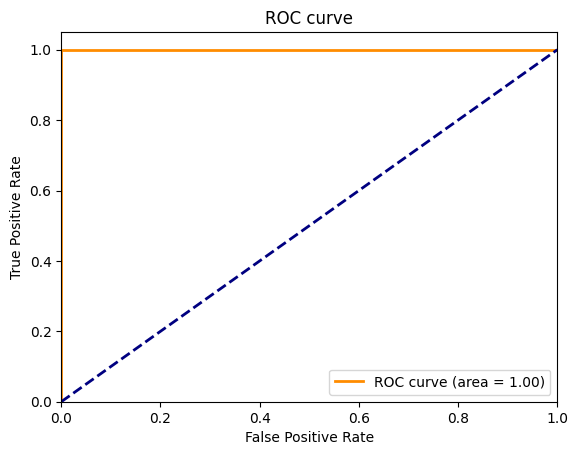

In [109]:
"""
Compute ROC and AOC
"""
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def compute_roc_auc(real_file_name, syn_file_name, gamma, delta, num_samples_per_class, num_tokens_per_sample):
    samples_dir = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples/"
    real_path = samples_dir + real_file_name
    syn_path = samples_dir + syn_file_name
    real_df = pd.read_csv(real_path)
    syn_df = pd.read_csv(syn_path)
    
    tokenizer = transformers.AutoTokenizer.from_pretrained('distilgpt2', add_prefix_space=True)
    tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.pad_token = tokenizer.eos_token
    great_watermark_processor = GreatWatermarkLogitProcessor(tokenizer=tokenizer,
                                                             device="cpu",
                                                             vocab=list(tokenizer.get_vocab().values()),
                                                             gamma=gamma,
                                                             delta=delta)
    great_watermark_detector = GreatWatermarkDetector(great_watermark_processor)
    
    # take samples each from the real and synthesized table
    real_scores = []
    gen_scores = []
    for i in range(num_samples_per_class):
        real_scores.append(great_watermark_detector.detect(real_df, total_tokens_limit=num_tokens_per_sample, random_state=i)['z_score'])
        gen_scores.append(great_watermark_detector.detect(syn_df, total_tokens_limit=num_tokens_per_sample, random_state=i)['z_score'])
    
    # Compute roc auc 
    y_true = np.concatenate([np.zeros(len(real_scores)), np.ones(len(gen_scores))])
    y_scores = np.concatenate([real_scores, gen_scores])
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc

def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

adult_fpr, adult_tpr, adult_roc_auc = compute_roc_auc(
    "california.csv",
    "california_1000_with-watermark_gamma-0.25_delta-2.0.csv",
    gamma=0.25,
    delta=2.0,
    num_samples_per_class=250,
    num_tokens_per_sample=500
)

plot_roc_curve(adult_fpr, adult_tpr, adult_roc_auc)

In [102]:
"""
Plot trade-off data quality and strength of watermark (avg z-score)
"""

''

In [29]:
compare(
    "abalone.csv",
    "abalone_v_baseline_1000_non-watermark.csv",
    "abalone_v_baseline_1000_with-watermark_gamma-0.25_delta-2.0.csv",
    1000
).to_csv("lmao.csv")

In [178]:
# very low since there's no target column
compare(
    "california.csv",
    "california_1000_non-watermark.csv",
    "california_1000_with-watermark_gamma-0.25_delta-2.0.csv",
    1000
)

,Real Data,No-Watermark,With-Watermark,Direction
sanity.data_mismatch.score,0.00,0.00,0.00,minimize
sanity.nearest_syn_neighbor_distance.mean,0.00,0.01,0.01,minimize
sanity.close_values_probability.score,1.00,0.98,0.98,maximize
stats.jensenshannon_dist.marginal,0.00,0.01,0.02,minimize
stats.ks_test.marginal,1.00,0.90,0.75,maximize
stats.max_mean_discrepancy.joint,0.00,0.00,0.00,minimize
stats.prdc.precision,1.00,0.99,1.00,maximize
stats.prdc.recall,1.00,0.94,0.96,maximize
stats.prdc.density,1.00,0.95,0.96,maximize
stats.prdc.coverage,1.00,0.85,0.62,maximize


In [82]:
# very low since there's no target column
average_data_quality(
    "diabetes.csv",
    "diabetes_v_baseline_1000_non-watermark.csv",
    "diabetes_v_baseline_1000_with-watermark_gamma-0.25_delta-2.0.csv",
    1000
)

{'resemblance': No-Watermark      0.803950
 With-Watermark    0.780705
 dtype: float64,
 'ml_performance': No-Watermark      0.866101
 With-Watermark    0.918098
 dtype: float64,
 'avg_final_score': No-Watermark      0.835025
 With-Watermark    0.849401
 dtype: float64}